coding: utf-8

In[ ]:

Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Deform a source mesh to form a target mesh using 3D loss functions

In this tutorial, we learn to deform an initial generic shape (e.g. sphere) to fit a target shape.<br>
<br>
We will cover: <br>
<br>
- How to **load a mesh** from an `.obj` file<br>
- How to use the PyTorch3D **Meshes** datastructure<br>
- How to use 4 different PyTorch3D **mesh loss functions**<br>
- How to set up an **optimization loop**<br>
<br>
<br>
Starting from a sphere mesh, we learn the offset to each vertex in the mesh such that<br>
the predicted mesh is closer to the target mesh at each optimization step. To achieve this we minimize:<br>
<br>
+ `chamfer_distance`, the distance between the predicted (deformed) and target mesh, defined as the chamfer distance between the set of pointclouds resulting from **differentiably sampling points** from their surfaces. <br>
<br>
However, solely minimizing the chamfer distance between the predicted and the target mesh will lead to a non-smooth shape (verify this by setting  `w_chamfer=1.0` and all other weights to `0.0`). <br>
<br>
We enforce smoothness by adding **shape regularizers** to the objective. Namely, we add:<br>
<br>
+ `mesh_edge_length`, which minimizes the length of the edges in the predicted mesh.<br>
+ `mesh_normal_consistency`, which enforces consistency across the normals of neighboring faces.<br>
+ `mesh_laplacian_smoothing`, which is the laplacian regularizer.

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In[ ]:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{pyt_version_str}"
#         ])
#         # get_ipython().system('pip install fvcore iopath')
#         # get_ipython().system('pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html')
#     else:
        # We try to install PyTorch3D from source.
        # get_ipython().system("pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'")

In[ ]:

In [2]:
import os
import torch
from scipy.special import comb
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
# get_ipython().run_line_magic('matplotlib', 'notebook')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Set the device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

Free Form Deformation (FFD)

In [4]:
class FFD(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)



In [54]:
class FFD:
    def __init__(self, l, m, n):
        """
        l, m, n são o número de pontos de controle na grade em cada dimensão.
        """
        self.l = l
        self.m = m
        self.n = n
        self.dimension = (l, m, n)
        # Inicializamos a grade de controle como uma grade uniforme no espaço [0,1]^3
        self.control_points = np.array([[[[i/(l-1), j/(m-1), k/(n-1)] for k in range(n)] for j in range(m)] for i in range(l)]).reshape(l*m*n,3)
        
        # self.control_points = 2 * self.control_points - 1
    
    def bernstein(self, i, n, u):
        """Função de base de Bernstein."""
        return comb(n, i) * (u**i) * ((1 - u)**(n - i))
    
    def derivative_bernstein(self, i, n, u):
        """Derivada da função de base de Bernstein usada algoritmo de backpropagation"""
        return -u**(-1+i) * comb(n, i) * (n*u-i) * ((1-u)**(n-1-i))
    
    def deform_points(self, points, control_points_delta):
        """
        Deforma os pontos da malha usando a grade de controle deformada.
        points: np.array de formato (N, 3), contendo os pontos da malha.
        control_points_delta: np.array de formato (l, m, n, 3) com os deslocamentos da grade de controle.
        """

        # Atualiza os pontos da grade de controle com o deslocamento
        control_points = self.control_points + control_points_delta
        
        deformed_points = np.zeros(points.shape)
        deformed_points_deltas = np.zeros(points.shape)
        
        for p_idx, p in enumerate(points):
            u, v, w = p  # Assumimos que os pontos estão normalizados no intervalo [0,1]
            
            new_point = np.zeros(3)
            
            for i in range(self.l):
                for j in range(self.m):
                    for k in range(self.n):
                        # Calculamos a contribuição de cada ponto de controle usando Bernstein
                        B_i = self.bernstein(i, self.l - 1, u)
                        B_j = self.bernstein(j, self.m - 1, v)
                        B_k = self.bernstein(k, self.n - 1, w)
                        
                        # Calculamos a posição deformada somando a contribuição ponderada de cada ponto de controle
                        new_point += B_i * B_j * B_k * control_points[i*4 + j*2 + k]
                    
            deformed_points[p_idx] = new_point
            deformed_points_deltas[p_idx] = new_point - points[p_idx]
        
        return deformed_points, deformed_points_deltas
    
    def deform_mesh(self, mesh, control_points_delta_array):
        """
        Deforma os pontos da malha usando a grade de controle deformada.
        points: np.array de formato (N, 3), contendo os pontos da malha.
        control_points_delta: np.array de formato (l, m, n, 3) com os deslocamentos da grade de controle.
        """
        control_points_delta = control_points_delta_array.detach().numpy().reshape((np.prod(self.dimension) , 3 ))
        mesh_verts = mesh.verts_packed().detach().cpu().numpy()
        mesh_verts = mesh_verts / 2 + 0.5
        _, deformed_mesh_points_deltas = self.deform_points(mesh_verts, control_points_delta)
        
        deformed_mesh_points_deltas_tensor = torch.tensor(deformed_mesh_points_deltas, requires_grad=True)

        # Cria nova malha substituindo os pontos originais pelos deformados
        new_mesh = mesh.offset_verts(deformed_mesh_points_deltas_tensor.float())
        return new_mesh
        

## 2. Visualize the source and target meshes

In [55]:
   
    def plot_deformation(self, original_points, deformed_points, control_points_delta):
        """
        Plota a malha e a grade de controle antes e depois da deformação.
        """
        fig = plt.figure(figsize=(12, 6))
        
        # Posição dos pontos de controle deformados
        deformed_control_points = self.control_points + control_points_delta
        
        # Plot original e deformado lado a lado
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        
        # Plotando malha original
        ax1.scatter(original_points[:, 0], original_points[:, 1], original_points[:, 2], color='blue', label='Malha Original')
        ax2.scatter(original_points[:, 0], original_points[:, 1], original_points[:, 2], color='blue', marker='^', label='Malha Original')
        ax2.scatter(deformed_points[:, 0], deformed_points[:, 1], deformed_points[:, 2], color='red', label='Malha Deformada')
        
        # Função para plotar as linhas de controle da grade
        def plot_control_grid(ax, control_points, title):
            for i in range(self.l):
                for j in range(self.m):
                    for k in range(self.n):
                        ax.scatter(*control_points[i, j, k], color='black')
            
            # Conecta os pontos ao longo de cada eixo
            # Conectar ao longo do eixo X
            for j in range(self.m):
                for k in range(self.n):
                    for i in range(self.l - 1):
                        ax.plot([control_points[i, j, k][0], control_points[i + 1, j, k][0]],
                                [control_points[i, j, k][1], control_points[i + 1, j, k][1]],
                                [control_points[i, j, k][2], control_points[i + 1, j, k][2]],
                                color='gray')
            
            # Conectar ao longo do eixo Y
            for i in range(self.l):
                for k in range(self.n):
                    for j in range(self.m - 1):
                        ax.plot([control_points[i, j, k][0], control_points[i, j + 1, k][0]],
                                [control_points[i, j, k][1], control_points[i, j + 1, k][1]],
                                [control_points[i, j, k][2], control_points[i, j + 1, k][2]],
                                color='gray')

            # Conectar ao longo do eixo Z
            for i in range(self.l):
                for j in range(self.m):
                    for k in range(self.n - 1):
                        ax.plot([control_points[i, j, k][0], control_points[i, j, k + 1][0]],
                                [control_points[i, j, k][1], control_points[i, j, k + 1][1]],
                                [control_points[i, j, k][2], control_points[i, j, k + 1][2]],
                                color='gray')
            
            ax.set_title(title)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_aspect('equal', adjustable='box')
        
        # Plotando a grade de controle
        plot_control_grid(ax1, self.control_points, "Malha e Grade Originais")
        plot_control_grid(ax2, deformed_control_points, "Malha e Grade Deformadas")
        
        ax1.legend()
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

## 1. Load an obj file and create a Meshes object

Download the target 3D model of a dolphin. It will be saved locally as a file called `dolphin.obj`.

In [56]:
get_ipython().system('wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj')

158605.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2024-11-23 18:55:18--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.83.48, 52.84.83.26, 52.84.83.109, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.83.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj.1’

dolphin.obj.1       100%[===================>] 153.09K  --.-KB/s    in 0.02s   

2024-11-23 18:55:19 (6.28 MB/s) - ‘dolphin.obj.1’ saved [156763/156763]



Load the dolphin mesh.

We read the target 3D model using load_obj

verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh<br>
faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx<br>
For this tutorial, normals and textures are ignored.

In [57]:
trg_obj = 'dolphin.obj'
verts, faces, aux = load_obj(trg_obj)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

trg_mesh = Meshes(verts=[verts], faces=[faces_idx])
src_mesh = ico_sphere(4, device)

/usr/local/lib/python3.8/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). <br>
(scale, center) will be used to bring the predicted mesh to its original center and scale<br>
Note that normalizing the target mesh, speeds up the optimization but is not necessary!

## 2. Visualize the source and target meshes

In [58]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In[ ]:

%matplotlib notebook

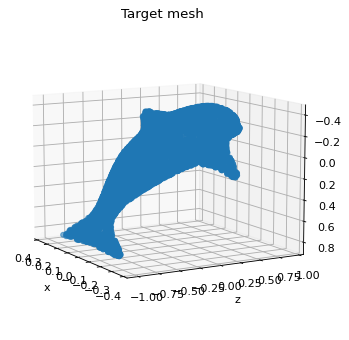

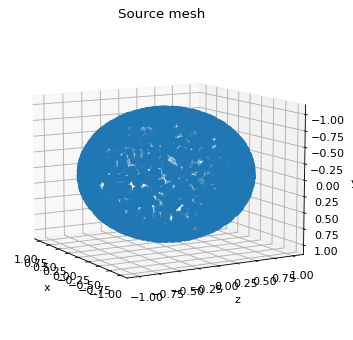

In [59]:
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

## 2.1. Check Deformation

In [60]:
ffd_instance = FFD(2,2,2)
ffd_instance.control_points

array([[0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 1.],
       [1., 0., 0.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 1., 1.]])

In [61]:
delta_control_points = torch.tensor([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0.5,0.5,0.5]])

In [ ]:
deformed_mesh = ffd_instance.deform_mesh(src_mesh,delta_control_points)

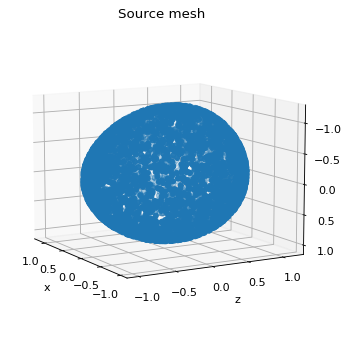

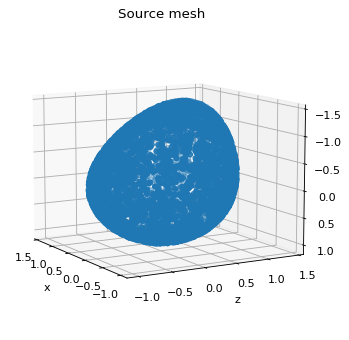

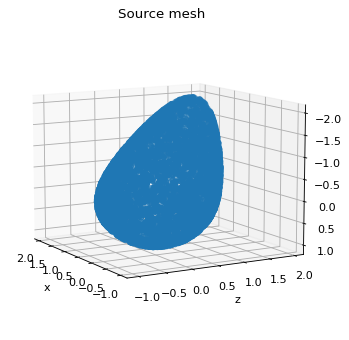

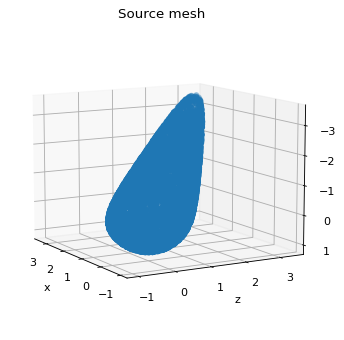

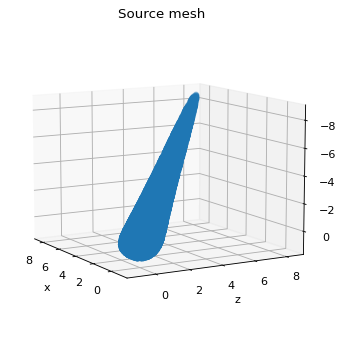

In [63]:
for i in range(5):
    plot_pointcloud(deformed_mesh, "Source mesh")
    deformed_mesh = ffd_instance.deform_mesh(deformed_mesh,delta_control_points)

## 3. Optimization loop 

In[ ]:<br>


In [ ]:
from functools import reduce

multiply = lambda x,y: x * y

In [ ]:
control_box_dimension = (3,3,3)
# control_box_size = reduce(multiply, control_box_dimension)
control_box_size = 27

We will learn to deform the source mesh by offsetting its vertices<br>
The shape of the deform parameters is equal to the total number of vertices in src_mesh<br>
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [ ]:
delta_control_points = torch.full(torch.Size([control_box_size, 3]), 0.0, device=device, requires_grad=True)

My new version will use only the offset of the vertices wich defines the FFD bonderies<br>
deform_verts_new = torch.full([num_boxes, 3], 0.0, device=device, requires_grad=True)

In[ ]:

The optimizer<br>
params  = iterable of parameters to optimize<br>
lr = learning rate<br>
optimizer = torch.optim.SGD(params = [deform_verts], lr=1.0, momentum=0.9)

In [ ]:
optimizer_control_box = torch.optim.SGD(params = [delta_control_points], lr=1.0, momentum=0.9)

In [ ]:
ffd = FFD(*control_box_dimension)
# In[ ]:

Number of optimization steps

In [ ]:
Niter = 201
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 50

chamfer_losses = []<br>
laplacian_losses = []<br>
edge_losses = []<br>
normal_losses = []

In [ ]:
chamfer_losses_ffd = []
laplacian_losses_ffd = []
edge_losses_ffd = []
normal_losses_ffd = []

get_ipython().run_line_magic('matplotlib', 'inline')

In [ ]:
for i in range(Niter):
    # Initialize optimizer
    # optimizer.zero_grad()
    optimizer_control_box.zero_grad()
    
    # Deform the mesh
    # new_src_mesh = src_mesh.offset_verts(deform_verts)
    new_src_mesh_ffd = ffd.deform_mesh(src_mesh, delta_control_points)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    # sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    sample_src_ffd = sample_points_from_meshes(new_src_mesh_ffd, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    # loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    loss_chamfer_ffd, _ = chamfer_distance(sample_trg, sample_src_ffd)
    
    # and (b) the edge length of the predicted mesh
    # loss_edge = mesh_edge_loss(new_src_mesh)
    loss_edge_ffd = mesh_edge_loss(new_src_mesh_ffd)
    
    # mesh normal consistency
    # loss_normal = mesh_normal_consistency(new_src_mesh)
    loss_normal_ffd = mesh_normal_consistency(new_src_mesh_ffd)
    
    # mesh laplacian smoothing
    # loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    loss_laplacian_ffd = mesh_laplacian_smoothing(new_src_mesh_ffd, method="uniform")
    
    # Weighted sum of the losses
    # loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    loss_ffd = loss_chamfer_ffd * w_chamfer + loss_edge_ffd * w_edge + loss_normal_ffd * w_normal + loss_laplacian_ffd * w_laplacian
    
    # Print the losses
    # print(f'iter{i}: total_loss = {loss:.6f}')
    print(f'iter{i}: total_loss = {loss_ffd:.6f}')
    
    # Save the losses for plotting
    # chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    # edge_losses.append(float(loss_edge.detach().cpu()))
    # normal_losses.append(float(loss_normal.detach().cpu()))
    # laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    chamfer_losses_ffd.append(float(loss_chamfer_ffd.detach().cpu()))
    edge_losses_ffd.append(float(loss_edge_ffd.detach().cpu()))
    normal_losses_ffd.append(float(loss_normal_ffd.detach().cpu()))
    laplacian_losses_ffd.append(float(loss_laplacian_ffd.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh_ffd, title="iter: %d" % i)
        # plot_pointcloud(new_src_mesh, title="iter: %d" % i)

In [ ]:
    # Optimization step
    # loss.backward()
    # optimizer.step()
    loss_ffd.backward()
    optimizer_control_box.step()

## 4. Visualize the loss

In[ ]:

In [ ]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

## 5. Save the predicted mesh

In[ ]:

Fetch the verts and faces of the final predicted mesh

In [ ]:
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

Scale normalize back to the original target size

In [ ]:
final_verts = final_verts * scale + center

Store the predicted mesh using save_obj

In [ ]:
final_obj = 'final_model.obj'
save_obj(final_obj, final_verts, final_faces)

## 6. Conclusion <br>
<br>
In this tutorial we learnt how to load a mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an optimization loop and use four different PyTorch3D mesh loss functions. 

%%